In [22]:
import requests
from PIL import Image
import numpy as np

import torch
import torchvision.transforms as transforms

from modules.utils import get_img_embeds_from_pretrained_model, calculate_similarity_score, print_preds_align_with_concepts

In [23]:
# Set device agnostic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# CONSTANTS
"""
Choose accordingly to the Model/Dataset being evaluated:
MODEL= {ViT-B-32, ViT-B-16, RN50, RN101, ViT-L-14, RN50x16} 
DATASET= {derm7pt}
"""
MODEL = "RN101"
DATASET = "derm7pt"
ADDITIONAL_COMMENTS = "CONCEPT_PROMPTS"
SEED = 42

In [29]:
# Get image from URL
#img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQshDpF4etpPT6mmMfBubZ-TAY3APwoGH33Mw&usqp=CAU'
img_url = 'https://www.saudebemestar.pt/media/88954/diagnostico-melanoma.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')  

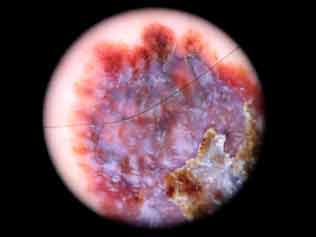

In [30]:
display(raw_image)

In [31]:
# Get image features from pretrained model
"""Remember to adjust parameters in CLIP/modules/config.py according to the selected model"""
model_path = "/home/cristianopatricio/Documents/concept-based-interpretability-VLM/CLIP/output/CLIP_derm7pt_RN101_42_Segmented.pt" # (change path according to your directories)
_, img_feats = get_img_embeds_from_pretrained_model(raw_image=raw_image, clip_model='RN101', model_path=model_path, device=device)

# Convert image features to torch tensor
img_feats = torch.from_numpy(img_feats).unsqueeze(0)

print(f"[INFO] Image features shape: {img_feats.shape}")

[INFO] Image features shape: torch.Size([1, 512])


In [32]:
####################################################################
# Calculate similarity between image and dermoscopic concepts
####################################################################

CONCEPT_PROMPTS = {
    "Asymmetry": ["This is dermatoscopy of an asymmetry"],
    "Irregular": ["This is dermatoscopy of irregular"],
    "Erosion": ["This is dermatoscopy of erosion"],
    "Black": ["This is dermatoscopy of black"],
    "Blue": ["This is dermatoscopy of blue"],
    "White": ["This is dermatoscopy of white"],
    "Brown": ["This is dermatoscopy of brown"],
    "Multiple Colors": ["This is dermatoscopy of multiple colors"],
    "Tiny": ["This is dermatoscopy of tiny"],
    "Regular": ["This is dermatoscopy of a regular"]
}

# Load reference embeddings (change path according to your directories)
reference_embeddings = torch.from_numpy(np.load(
    f"/home/cristianopatricio/Documents/concept-based-interpretability-VLM/CLIP/output/{MODEL}/text_embeddings/reference_embeddings__{DATASET}_{MODEL}-Fine-Tuned_{SEED}.npy")).unsqueeze(0)

# Weights of Melanoma (Fig. 5 (I) of reference [16])
weights_melanoma = np.array([[1.9, 2.0, 3.84, 1.6, 0.15, 0.0, 2.4, 8.66, -0.05, -0.15]])

similarity_scores = []
for disease_label in CONCEPT_PROMPTS.keys():
    # Load text features (change path according to your directories)
    text_feats = torch.from_numpy(np.load(
        f"/home/cristianopatricio/Documents/concept-based-interpretability-VLM/CLIP/output/{MODEL}/text_embeddings/concept_embeddings_{disease_label}_{DATASET}_{MODEL}-Fine-Tuned_{SEED}.npy")).unsqueeze(
        0)

    # Calculate similarity
    similarity = calculate_similarity_score(image_features_norm=img_feats,
                                            prompt_target_embedding_norm=text_feats,
                                            prompt_ref_embedding_norm=reference_embeddings,
                                            top_k=-1,
                                            temp=(1 / np.exp(4.5944)),
                                            normalize=False)

    similarity_scores.append(similarity[0])

# Calculate prediction given weights of melanoma
y_pred = np.dot(weights_melanoma, np.array(similarity_scores))
concept_predictions = np.array(similarity_scores)

In [33]:
# Print results
print("######## Prediction ########")
print(f"MEL_weights @ similarity_scores: {y_pred[0]:.2f}")
print("\n")
print("######## Concepts Relevance ########")
print_preds_align_with_concepts(concept_predictions*100) # Scale it by 100 for better understanding

######## Prediction ########
MEL_weights @ similarity_scores: 0.61


######## Concepts Relevance ########
Asymmetry: -0.16
 Irregular: 1.18
 Erosion: 0.05
 Black: 7.09
 Blue: 7.26
 White: 2.73
 Brown: 2.93
 Multiple Colors: 4.60
 Tiny: -0.37
 Regular: 1.48

